# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,2.327554,True,7.295338
1,0.300997,True,4.985168
2,1.597787,True,8.775421
3,-1.058256,False,-1.614466
4,-1.270350,False,-1.858618
...,...,...,...
995,1.221505,True,6.613928
996,0.884511,False,0.929254
997,1.672671,True,7.049152
998,0.123448,True,4.409866


<Axes: xlabel='v0'>

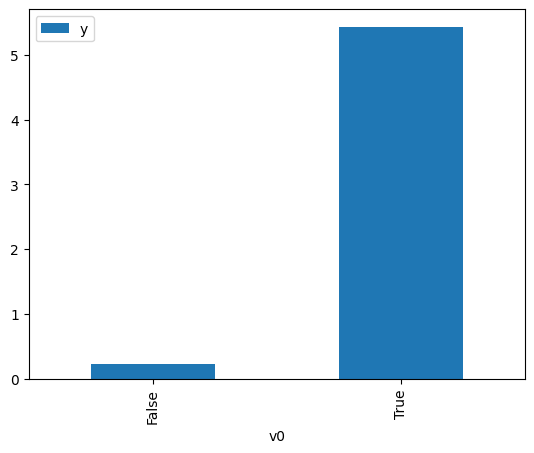

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

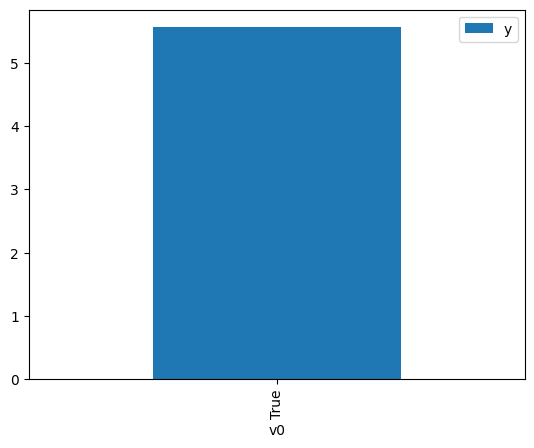

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.813217,False,-0.733449,0.775372,1.289703
1,0.400255,False,-0.526615,0.314212,3.182562
2,-1.338246,False,0.487254,0.892124,1.120920
3,1.274076,False,2.733615,0.096680,10.343376
4,-0.546134,False,-0.556465,0.688782,1.451838
...,...,...,...,...,...
995,0.867020,False,-0.875594,0.174039,5.745831
996,-2.015217,False,-2.386520,0.962283,1.039195
997,0.159934,False,-0.794646,0.405989,2.463120
998,-1.155762,False,-0.013463,0.859234,1.163827


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.075055,True,4.289411,0.497379,2.010541
1,0.482648,True,6.135437,0.714556,1.399471
2,0.679806,True,6.360557,0.776557,1.287735
3,-1.390593,True,4.304158,0.099774,10.022638
4,2.120116,True,6.464159,0.974484,1.026184
...,...,...,...,...,...
995,0.695076,True,6.215404,0.780936,1.280515
996,-0.145245,True,5.125035,0.468220,2.135750
997,-0.354777,True,5.664891,0.383201,2.609599
998,-1.363767,True,5.156324,0.103856,9.628715


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.957
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                          1.114e+04
Date:                Fri, 08 Aug 2025   Prob (F-statistic):                        0.00
Time:                        19:51:24   Log-Likelihood:                         -1427.2
No. Observations:                1000   AIC:                                      2858.
Df Residuals:                     998   BIC:                                      2868.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9146      0.037     24.728      0.000       0.842       0.987
x2             5.0594      0.051     99.450      0.000       4.960       5.159
==============================================================================
Omnibus:                        2.193   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.334   Jarque-Bera (JB):                2.080
Skew:                           0.051   Prob(JB):                        0.353
Kurtosis:                       2.801   Cond. No.                         2.25
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""